<a href="https://colab.research.google.com/github/ShoSato-047/STAT380/blob/main/STAT380_3_2_(2025)_Towards_a_GLM_multi_parameter_likelihoods_and_comparing_likelihoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the previous notebook, we defined likelihoods for an outcome $Y$ and the method of maximum likelihood for estimating model parameters.  But what about when we incorporate $X$ terms?  

In this notebook, we will:

* Fit likelihoods that depend on $X$
* Discuss how to extend the maximum likelihood estimation technique to multiple parameters
* Describe likelihood-based methods for comparing fitted models, including:
  - Likelihood ratio test
  - AIC
  - BIC



# Case study: Twins data


Reconsider data from the Minnesota Twins 2022 season, scraped from [boxscores on the Fangraphs website](https://www.fangraphs.com/boxscore.aspx?date=2022-04-15&team=Twins&dh=0&season=2022)

In [1]:
twins <- read.csv('https://www.dropbox.com/s/6cl8crdkyk1ptbt/twins22.csv?dl=1')
head(twins)

,date,month,opponent,win,home.away,score,twins.HR,opponent.HR
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
1,2022-04-08,Apr,Mariners,0,home,1-2,1,1
2,2022-04-09,Apr,Mariners,0,home,3-4,2,1
3,2022-04-10,Apr,Mariners,1,home,10-4,6,1
4,2022-04-11,Apr,Mariners,1,home,4-0,0,0
5,2022-04-12,Apr,Dodgers,0,home,2-7,0,0
6,2022-04-13,Apr,Dodgers,0,home,0-7,0,4


## Home field advantage

Let $Y$ represent the binary variable indicating whether or not the Twins won their game.  Is there a home field advantage?  I.e., given:

$$X=\begin{cases} 1;& Home\\ 0; & Away\\ \end{cases}$$

can $X$ be used to explain $p$, the probability that $Y=1$?



# Exploratory analysis

Before any formal likelihood modeling let's explore the data to see if there seems to be a relationship between $X$ and $Y$.

In [2]:
# Finding win % for home and away games
library(dplyr)
(twins
  %>% group_by(home.away, win)
  %>% summarize(n = n())
  %>% mutate(win.pct = n/sum(n))
)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


`summarise()` has grouped output by 'home.away'. You can override using the
`.groups` argument.


home.away,win,n,win.pct
<chr>,<int>,<int>,<dbl>
away,0,49,0.6049383
away,1,32,0.3950617
home,0,35,0.4320988
home,1,46,0.5679012


The Twins went 32-49 in away games, a winning percentage of only 0.395.  At home they were much better, going 46-35 for a winning percentage of 0.568.  There certainly seemed to be a home field advantage.  In other words, it certainly seems like $X$ has something to say about the parameter $p$ governing the distribution of $Y$.

Graphing these results:

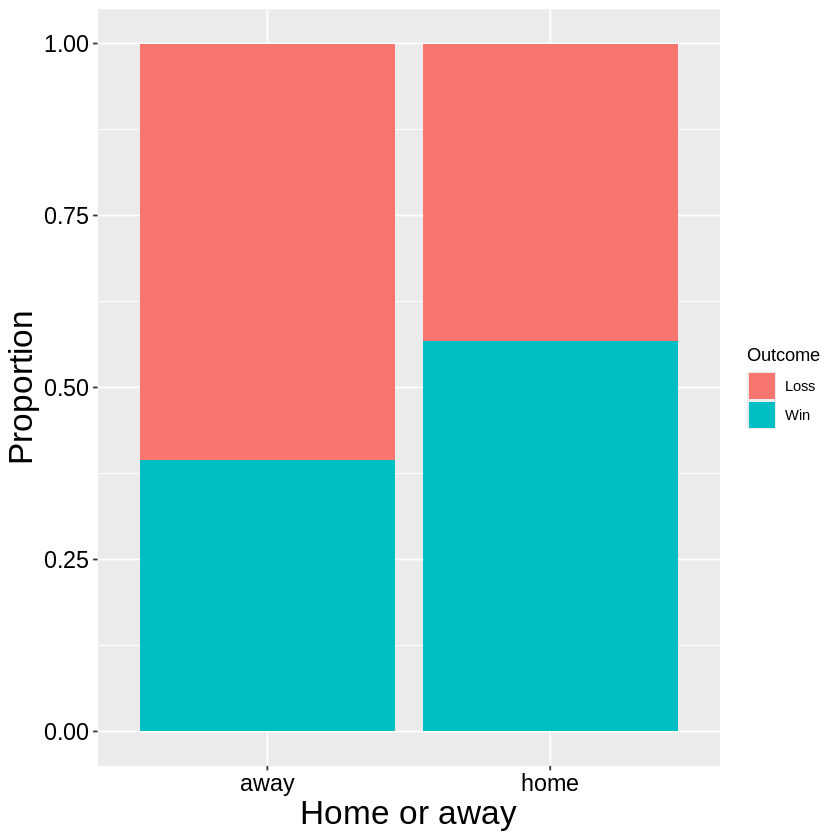

In [3]:
library(ggplot2)
ggplot(data = twins) +
  geom_bar(aes(x = home.away, fill = factor(win)), position='fill') +
     ylab('Proportion') + xlab('Home or away') +
      theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black')) +
        scale_fill_discrete(name = 'Outcome',labels = c('Loss','Win'))

# Likelihood for multiple parameters

Saying that $X$ changes $p$, the probability of a win, means that $p$ *changes* depending on whether $X$ is *home* or *away*.  In other words, one $p$ is not enough to explain $Y$: we need two $p$'s.

Accordingly, we'll let $p_H$ indicate $P(Y=1 | X = 1)$ and $p_A$ indicate $P(Y=1 | X=0)$.  Then we have:


$$\begin{align}
P(Y_i = 1 | X_i = 1) &= p_H\\
P(Y_i = 0 | X_i = 1) &= (1-p_H)\\
P(Y_i = 1 | X_i = 0) &= p_A\\
P(Y_i = 0 | X_i = 0) &= (1-p_A)
\end{align}$$


The log-likelihood is:

$$logLik(p_H,p_A) = \sum_{i=1}^n\log(P(Y_i = k_i | X_i)),$$


where $k_i$ is the actual observed outcome of game $i$, and $X_i$ is the home field status of game $i$.

Each data point (game) will contribute a $p_A$, a $(1-p_A)$, a $p_H$, or a $(1-p_H)$ to this log-likelihood, depending on the home/away and win status of the game.


Let's see this through a subset of 7 games:

In [ ]:
twins %>%
  slice(4:10)

date,month,opponent,win,home.away,score,twins.HR,opponent.HR
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
2022-04-11,Apr,Mariners,1,home,4-0,0,0
2022-04-12,Apr,Dodgers,0,home,2-7,0,0
2022-04-13,Apr,Dodgers,0,home,0-7,0,4
2022-04-15,Apr,Red Sox,1,away,8-4,1,2
2022-04-16,Apr,Red Sox,0,away,0-4,0,2
2022-04-17,Apr,Red Sox,0,away,1-8,0,0
2022-04-18,Apr,Red Sox,1,away,8-3,2,1


We have the following Model 2 probabilities of each of these observed outcomes:

* 4/11: a home win: $P(Y=1|X=1) = p_H$
* 4/12: a home loss: $P(Y=0|X=1) = 1-p_H$
* 4/13: another home loss; $P(Y=0|X=1) = 1-p_H$
* 4/15: A road win; $P(Y=1|X=0) = p_A$
* 4/16: A road loss; $P(Y=0|X=0) = 1-p_A$
* 4/17: A road loss; $P(Y=0|X=0) = 1-p_A$
* 4/18: A road win; $P(Y=1|X=0) = p_A$

The total contribution to the Model 2 log-likelihood from these 7 games is:

$$\log(p_H) + \log(1-p_H) + \log(1-p_H)+ \log(p_A)+ \log(1-p_A) +  \log(1-p_A) + \log(p_A)$$
$$ = \log(p_H) + 2\log(1-p_H) + 2\log(p_A) + 2\log(1-p_A)$$


Thus, each home win contributes a $\log(p_H)$; each home loss contributes a $\log(1-p_H)$; each away win contributes a $\log(p_A)$; and each away loss contributes a $\log(1-p_A)$.  


Tabulating the contributions, and number of games that contribute this:

$X$ | $Y$ | Contribution to $logLik$ | Number of observations |
--- | --- | --- | --- |
Away | Loss | $\log(1-p_A)$ |  49 |
Away | Win | $\log(p_A)$ | 32 |
Home | Loss | $\log(1-p_H)$ | 35 |
Home | Win | $\log(p_H)$ | 46

Thus, the log-likelihood is:

$$logLik(p_A, p_H) = 49\log(1-p_A) + 32 \log(p_A) + 35 \log(1-p_H) + 46 \log(p_H)$$

## Maximizing the multi-parameter log-likelihood

The function below evaluates the log-likelihood for a *vector* of parameters.  A vector-valued argument is required for subsequent optimization:

In [5]:
##Function that returns the log-likelihood of the data for a given pvec=c(pA, pH):
loglik.pApH <- function(pvec) {
 pA <- pvec[1]
 pH <- pvec[2]
 out <- 49*log(1-pA) + 32*log(pA) + 35*log(1-pH) + 46*log(pH)
 return(out)
}

The resulting log-likelihood is only [visualized in 3D](https://www.math3d.org/sn6Vb6XXN):

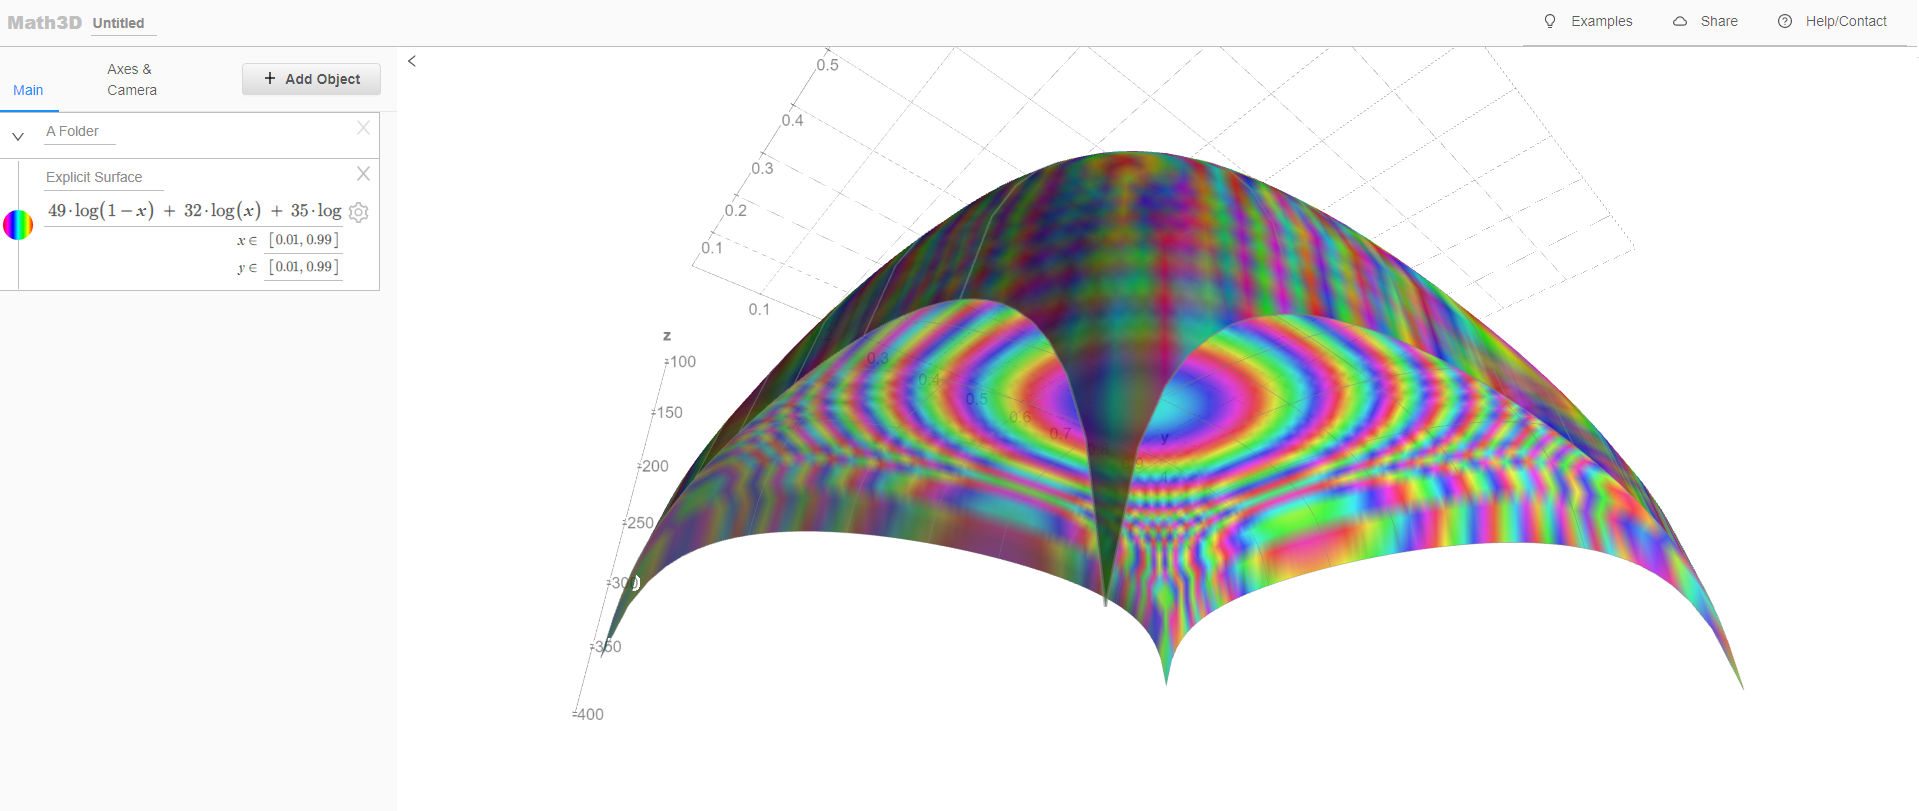


Note the highest point on this log-likelihood appears to be somewhere a bit lower than $p_A = 0.4$ and a bit higher than $p_H = 0.5$:

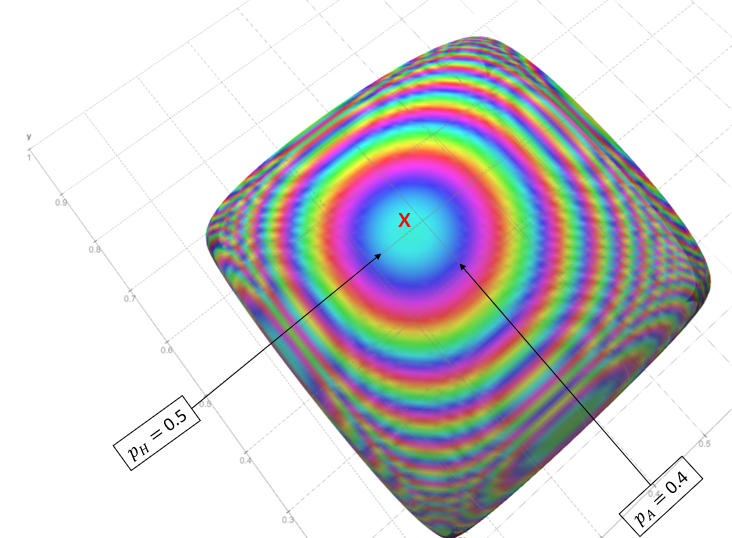

Finding the MLEs with `optim()`; arguments:

* `par`: initial values for the two parameters
* `fn`: the function that you want to optimize
* `control=list(fnscale = -1)`: by default, `optim()` minimizes and has no `maximum=TRUE` option, like the one-parameter `optimize()` function does.  So to use `optim()` to find a maximum, we multiply the log-likelihood by $-1$, so that we are minimizing the negative log-likelihood: this is the same thing as maximizing the log-likelihood.

See the bowl analogy; the place where the upside-down bowl (log-likelhood) is tallest is the same place where the right-side-up bowl (negative log-likelihood) is smallest:

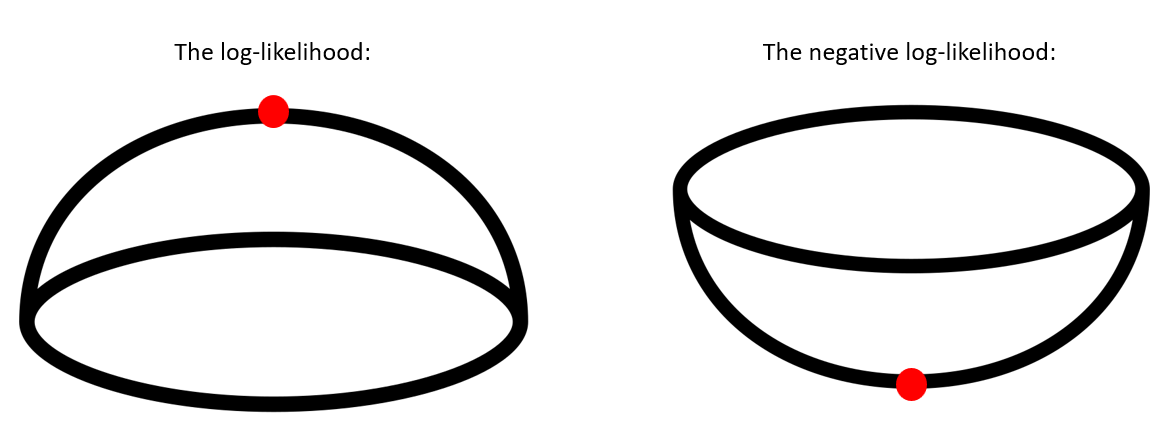

In [6]:
# 0.395 and 0.567 tells winning% in away/home
optim(par = c(0.5, 0.5), loglik.pApH, control = list(fnscale = -1))

$par
[1] 0.3950796 0.5678379

$value
[1] -109.7433

$counts
function gradient 
      45       NA 

$convergence
[1] 0

$message
NULL

Note the maximum likelihood estimators are:

* $\hat p_A = 0.395$: the observed winning percentage in away games!
* $\hat p_H = 0.568$: the observed winning percentage in home games!

The log-likelihood evaluated at the MLEs is:

$$logLik(0.395, 0.568) = -109.74.$$

While not really interpretable on its own, the value of the log-likelihood at its maximum is useful for *comparing* different models.  That's what we'll do next.

# Likelihood-based model comparisons

## AIC and BIC

Remember how you used to compare models with $R^2$ values in your regression class?  Higher $R^2$, better fit.  For generalized modeling settings, we use the log-likelihood to measure model fit.  Higher values of $logLik$ indicate better fit.



Remember also, though, that the more parameters you estimate the better your $R^2$?  The same is true for the log-likelihood: a maximized log-likelihood of 3 parameters will always be higher than a maximized log-likelihood with 2 parameters, etc.  In ordinary regression you computed an $R^2_{adj}$ that balanced model fit with model simplicity

The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) are two generalized ways of balancing model fit with model simplicity.  These metrics are:

$$\mbox{AIC} = -2(\mbox{maximum log-likelihood}) + 2(\mbox{# of parameters})$$
$$\mbox{BIC} = -2(\mbox{maximum log-likelihood}) + \log(n)(\mbox{# of parameters})$$

When comparing models, those with the smaller AIC or BIC are better.  This is because:

* Better fit ⟶  higher maximum log-likelihood, thus smaller values of $-2(\mbox{maximum log-likelihood})$.  
* Simpler model ⟶ smaller # of parameters.

The BIC penalizes the number of parameters with $\log(n)$ instead of 2, thus prioritizes simplicity more than AIC does (especially for large $n$).  

### Example: winning percentage

Recall the maximized log-likelihood for the 2-parameter ($p_A$ and $p_H$) model to describe the Twins' winning percentage:

In [7]:
optim(par = c(0.5, 0.5), loglik.pApH, control = list(fnscale = -1))$value

[1] -109.7433

Without $X$, the home/away status, to model $Y$ there is only one $p$: the overall probability of winning.  We considered this log-likelihood in the previous notebook:

$$logLik(p) = (\mbox{# of wins})\log(p) + (\mbox{# of losses})\log(1-p)$$

In [8]:
##Function that returns the log-likelihood of the data for a given p:
loglik.wins <- function(p) {
 out <- 78*log(p) + 84*log(1-p)
 return(out)
}

In [9]:
#Maximizing this log-likelihood:
optimize(loglik.wins, interval = c(0,1), maximum=TRUE)

$maximum
[1] 0.4814815

$objective
[1] -112.1787

* How does the maximized log-likelihood from the one-parameter model compare to the maximized log-likelihood from the two-parameter model?
  - **It is worth (lower): -112.18 from one-parameter model, -109.74 from two-parameter model.**

* Find and compare the AIC of the one- and two-parameter models.

In [10]:
# AIC of Model 1 (1 parameter model):
-2 * -112.18 + 2 * 1

[1] 226.36

In [11]:
# AIC of Model 2 (2 parameter model):
-2 * -109.74 + 2 * 2

[1] 223.48

* Find and compare the BIC of the one- and two-parameter models.

In [12]:
# BIC of Model 1 (1 parameter model):
-2 * -112.18 + log(162) * 1

[1] 229.4476

In [13]:
# BIC of Model 2 (2 parameter model):
-2 * -109.74 + log(162) * 2

[1] 229.6552


* Do these results indicate that the two-parameter model is enough of an improvement in model fit to warrant an additional parameter?  Explain.
  - **AIC suggests that model 2 is better, so much si as to warrant an additional parameter.**
  - **BIC suggests that Model 2 is not enough of an imporvement upon Model 1 to warrant the additional parameters.**

## Likelihood ratio test

Another way to compare models is via the likelihood ratio test, or LRT.  ***The LRT can be used to compare nested models only***, i.e. when a "large" model is being compared to a "simpler" model that contains a subset of the "large" model's parameters.  In this way, it's the generalized analogue to the nested-model ANOVA you learned about in STAT 360.

The LRT is a test of the following hypotheses:

$$H_0: \mbox{Simple model is sufficient}$$
$$H_a: \mbox{Larger model is an improvement}$$



It is based on the ratio of the maximized likelihoods:

$$\Lambda = 2\cdot \log\left(\frac{\mbox{maximized likelihood(large model)}}{\mbox{maximized likelihood(simpler model)}}\right)$$

Using properties of logarithms, we can express this test statistic $\Lambda$ as a function of the difference in log-likelihoods:

$$\Lambda = 2\left(\mbox{maximized log-likelihood(large model)}-\mbox{maximized log-likelihood(simpler model)}\right)$$

A big improvement from fitting the large model will result in a large value of $\Lambda$.  Determining whether the improvement is "significant" can be determined by comparing $\Lambda$ to a $\chi^2$ distribution with  $df=\mbox{# parameters in large model}-\mbox{# parameters in simpler model}$.

## Example: winning percentage

Let's carry out the likelihood ratio test with our winning percentage example.  

* Find the difference in the maximized log-likelihoods between the 2-parameter home/away $p_H$/$p_A$ model, and the 1-parameter "overall $p$" model


In [14]:
# Difference in maximized log-likelihoods
# Always be positive
-109.74 - - 112.18

[1] 2.44

* Find the likelihood ratio test statistic, $\Lambda$.


In [16]:
# This is something = similar to F-stat
LambdaStat <- 2*(-109.74 - - 112.18)
LambdaStat

[1] 4.88


* Determine whether $\Lambda$ represents a "significant improvement" in model fit by comparing it to a $\chi^2$ distribution and finding the p-value.
  - Since the "large" model has 2 parameters and the "simple" model only 1, the degrees-of-freedom are 2-1 = 1.
  - Use [StatKey](https://www.lock5stat.com/StatKey/)
  - Use `pchisq()` in a code chunk below


In [18]:
# P-value, probability if observing 4.88 Or LARGER:
# (pchisq finds 4.88 Or LOWER by default)
1 - pchisq(4.88, df = 2-1)

[1] 0.02716962

**p-value = 0.027 < 0.05, so we have sufficient evidence that the 2-parameter model improves the fit: meaningful relationship between X (home/away) and Y (winning %).**